# ASSIGNMENT 1 (adapted from https://bit.ly/2J7G9f8)

## PROBLEM:

### Context

Kiva.org is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people.

In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.

Submissions in this challenge will take the form of Python data analysis.

Kiva has provided a dataset of loans issued over the 2014-2018 time period, and participants are invited to use this data as well as source external public datasets to help Kiva build models for assessing borrower welfare levels. With a stronger understanding of their borrowers and their poverty levels, Kiva will be able to better assess and maximize the impact of their work.


### Problem statement

For the locations in which Kiva has active loans, the objective is to pair Kiva's data with additional data sources to estimate the welfare level of borrowers in specific regions, based on shared economic and demographic characteristics.

A good solution would connect the features of each loan or product to one of several poverty mapping datasets, which indicate the average level of welfare in a region on as granular a level as possible. Many datasets indicate the poverty rate in a given area, with varying levels of granularity. Kiva would like to be able to disaggregate these regional averages by gender, sector, or borrowing behavior in order to estimate a Kiva borrower’s level of welfare using all of the relevant information about them. Strong submissions will attempt to map vaguely described locations to more accurate geocodes.

### Personal disclaimer

From a research perspective, the results obtained are never going to be a full representation of the realities that borrowers experience. It is meant to spark a discussion around how we can identify the welfare level of borrowers and improve them where we can.

## SOLUTION:

**insert image summarizing the story here**

### Python Packages

In [1]:
# Packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cartopy.crs as ccrs

### Data
*Here we upload all the Python packages and datasets required for analysis*

#### 1. Original Data

In [2]:
# Original Data
loan_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//kiva_loans.csv')
location_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//kiva_mpi_region_locations.csv')
loan_themes  = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//loan_theme_ids.csv')
regional_lts = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//loan_themes_by_region.csv')

##### Descriptions of the original datasets

There are four data sources provided by Kiva:

* ***loan_data***
   1. **id** - Unique ID for loan
   2. **funded_amount** - The amount disbursed by Kiva to the field agent(USD)
   3. **loan_amount** - The amount disbursed by the field agent to the borrower(USD)
   4. **activity** - More granular category
   5. **sector** - High level category
   6. **use** - Exact usage of loan amount
   7. **country_code** - ISO country code of country in which loan was disbursed
   8. **country** - Full country name of country in which loan was disbursed
   9. **region** - Full region name within the country
   10. **currency** - The currency in which the loan was disbursed
   11. **partner_id** - ID of partner organization
   12. **posted_time** - The time at which the loan is posted on Kiva by the field agent
   13. **disbursed_time** - The time at which the loan is disbursed by the field agent to the borrower
   14. **funded_time** - The time at which the loan posted to Kiva gets funded by lenders completely
   15. **term_in_months** - The duration for which the loan was disbursed in months
   16. **lender_count** - The total number of lenders that contributed to this loan
   17. **tags**
   18. **borrower_genders** - Comma separated M,F letters, where each instance represents a single male/female in the group
   19. **repayment_interval**
   20. **date**
   
####  

* ***location_data***
   1. **LocationName** - region, country
   2. **ISO** - some sort of unique abbreviation for country   
   3. **country** - country   
   4. **region** - region within country   
   5. **world_region** - parts of the world   
   6. **MPI** - multidimensional poverty index   
   7. **geo** - (latitude, longitude)
   8. **lat** - latitude   
   9. **lon** - longitude
   
####  

* ***loan_themes***
   1. **id** - Unique ID for loan (Loan ID)   
   2. **Loan Theme ID** - ID for Loan Theme   
   3. **Loan Theme Type** - Category name of type of loan   
   4. **Partner ID**
   
####  

* ***regional_lts***
   1. **Partner ID**   
   2. **Field Partner Name**
   3. **sector**
   4. **Loan Theme ID**
   5. **Loan Theme Type**  
   6. **country**   
   7. **forkiva**   
   8. **region**
   9. **geocode_old**   
   10. **ISO**   
   11. **number**
   12. **amount**
   13. **LocationName**
   14. **geocode**
   15. **names**
   16. **geo**
   17. **lat**
   18. **lon**
   19. **mpi_region**
   20. **mpi_geo**
   21. **rural_pct**




In [3]:
loan_data.head(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [4]:
location_data.head(5)

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [5]:
loan_themes.head(5)

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0


In [6]:
regional_lts.head(5)

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
0,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,...,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
1,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,...,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
2,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,...,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
3,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,604950,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
4,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,275,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0


#### 2. Supplementary Data

In this section, we aim to gather the following data from the World Bank:

1. [Per Capita Expenditure (PCE)](https://www.quora.com/What-does-per-capita-expenditure-mean?share=1) for each country - *this is the total market value of all purchases in a country divided by that country's total population* (data: https://bit.ly/3blw0be)
2. [Multidimensional poverty headcount ratio](https://duckduckgo.com/?t=ffab&q=headcount+ratio+meaning&ia=web) - *this is the proportion of a country's population that lives, below the poverty line.* (data: https://bit.ly/2VfM2hi)
3. [GDP per capita (2011 PPP)](http://hdr.undp.org/en/content/gdp-per-capita-2011-ppp) for each country - *this is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products, expressed in international dollars using purchasing power parity rates and divided by total population of the same period.*

In [7]:
# Per Capita Expenditure
PCE_data = pd.read_html('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//PCE data.html')
PCE_data = PCE_data[0]
PCE_data = pd.DataFrame(PCE_data)

# World Bank Gross data
db_data = pd.read_csv('C://Users//CT//Documents//data-science-for-good-kiva-crowdfunding//Data_Extract_From_Poverty_and_Equity//806b9aec-08c0-45f0-8acc-e02a84ec7c9c_Data.csv')

In [8]:
PCE_data.head(5)

,Unnamed: 0,1977,1978,1979,1980,1981,1982,1983,1984,1985,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 43
0,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,East Asia and Pacific,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,American Samoa,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04,...,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,NaN
2,Cambodia,7.20,6.96,6.77,6.69,6.75,6.92,7.17,7.45,7.71,...,14.31,14.54,14.78,15.03,15.27,15.52,15.77,16.01,16.25,NaN
3,China,943.46,956.17,969.01,981.24,993.89,1008.63,1023.31,1036.83,1051.04,...,1337.71,1344.13,1350.70,1357.38,1364.27,1371.22,1378.67,1386.40,1392.73,NaN
4,Fiji,0.60,0.61,0.62,0.64,0.65,0.67,0.69,0.70,0.71,...,0.86,0.86,0.87,0.87,0.87,0.87,0.87,0.88,0.88,NaN


In [9]:
db_data.head(5)

,Series Name,Series Code,Country Name,Country Code,1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],...,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019]
0,Poverty headcount ratio at $1.90 a day (2011 P...,SI.POV.DDAY,Afghanistan,AFG,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
1,Poverty headcount ratio at $1.90 a day (2011 P...,SI.POV.DDAY,Albania,ALB,..,..,..,..,..,..,...,..,..,1.1,..,1.9,1.3,1.1,1.7,..,..
2,Poverty headcount ratio at $1.90 a day (2011 P...,SI.POV.DDAY,Algeria,DZA,..,..,..,..,..,..,...,..,0.5,..,..,..,..,..,..,..,..
3,Poverty headcount ratio at $1.90 a day (2011 P...,SI.POV.DDAY,Angola,AGO,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,47.6,..
4,Poverty headcount ratio at $1.90 a day (2011 P...,SI.POV.DDAY,Argentina,ARG,..,..,..,..,..,..,...,2.2,0.9,0.8,0.7,0.7,..,0.7,0.5,1,..


In [10]:
db_data['Series Name'].unique()

array(['Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
       'Poverty headcount ratio at national poverty lines (% of population)',
       'Survey mean consumption or income per capita, total population (2011 PPP $ per day)',
       nan, 'Data from database: Poverty and Equity',
       'Last Updated: 03/18/2020'], dtype=object)

### Exploratory Data Analysis

#### The impact of KIVA donors

In this section, we seek to explore the data to answer certain questions around KIVA donor contributions

##### 1. How much of the total loan amount has Kiva financed?

In [11]:
# calculate the percentage of loan requests that have been funded
percentage1 = (loan_data.funded_amount.sum()/loan_data.loan_amount.sum())*100
percentage1 = round(percentage1, 2)

# display the result
print('Kiva has financed '+str(percentage1)+"% of its borrowers' loans")

Kiva has financed 93.3% of its borrowers' loans


##### 2. How much money have Kiva donors contributed over time?

In [12]:
# convert datetime values to appropriate formats
loan_data['posted_time'] = loan_data['posted_time'].astype('datetime64')
loan_data['disbursed_time'] = loan_data['disbursed_time'].astype('datetime64')
loan_data['funded_time'] = loan_data['funded_time'].astype('datetime64')

# pick out dates
loan_data.loc[:,'disbursement_date'] = loan_data['disbursed_time'].dt.date
loan_data['disbursement_date'] = loan_data['disbursement_date']

In [13]:
# confirming datatype conversion
loan_data.dtypes

id                             int64
funded_amount                float64
loan_amount                  float64
activity                      object
sector                        object
use                           object
country_code                  object
country                       object
region                        object
currency                      object
partner_id                   float64
posted_time           datetime64[ns]
disbursed_time        datetime64[ns]
funded_time           datetime64[ns]
term_in_months               float64
lender_count                   int64
tags                          object
borrower_genders              object
repayment_interval            object
date                          object
disbursement_date             object
dtype: object

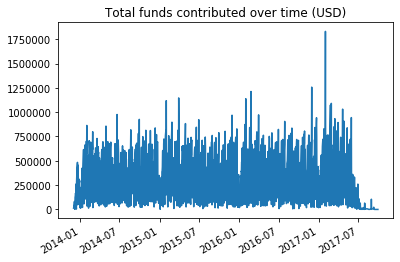

In [14]:
# create a pivot-table
tab1 = pd.pivot_table(loan_data, values='funded_amount', index=['disbursement_date'], aggfunc='sum')

# plot this table
fig, ax = plt.subplots()
ax.plot(tab1.index, tab1['funded_amount'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# declare the title and show the completed graph
ax.set_title('Total funds contributed over time (USD)')
plt.show()

The distribution of their daily contribution is as follows:

Characteristics of daily contributions in USD '000
count    1364.000000
mean      385.591441
std       265.123196
min         0.025000
25%       103.512500
50%       428.562500
75%       596.518750
max      1830.375000
Name: funded_amount, dtype: float64

     mode: 
0    51.275
dtype: float64


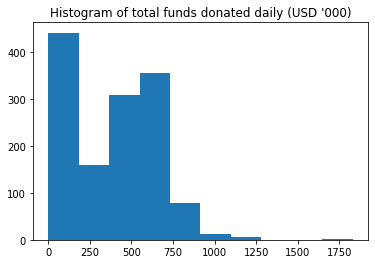

In [15]:
# convert data to thousands of US dollars for ease of visualization
funded_amount_in_thousands = tab1['funded_amount']/1000

# display characteristics of daily contributions

print("Characteristics of daily contributions in USD '000")
print(funded_amount_in_thousands.describe())
print('')
print('     mode: ')
print(funded_amount_in_thousands.mode())

# plot daily amounts distribution
fig, ax = plt.subplots()


ax.hist(funded_amount_in_thousands)

ax.set_title("Histogram of total funds donated daily (USD '000)")
plt.show()

##### 3. How much money have Kiva donors given to individual loans?

In [16]:
# create a pivot-table
loan_count_per_funded_amount = pd.pivot_table(loan_data, values='id', index=['funded_amount'], aggfunc='count')

# rename the column
loan_count_per_funded_amount.columns = ['number_of_loans']

# sort the results in descending order
loan_count_per_funded_amount = loan_count_per_funded_amount.sort_values(by=['number_of_loans'], ascending=False)

# and display top 10 results
loan_count_per_funded_amount.head(10)

,number_of_loans
funded_amount,
225.0,34402
300.0,30676
200.0,27445
500.0,27318
250.0,26704
125.0,26254
400.0,23847
350.0,22270
325.0,21065


Characteristics of total funds donated to individual loans in USD
count    671205.000000
mean        785.995061
std        1130.398941
min           0.000000
25%         250.000000
50%         450.000000
75%         900.000000
max      100000.000000
Name: funded_amount, dtype: float64



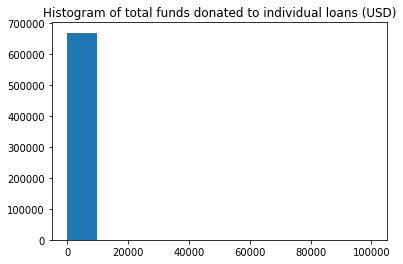

In [17]:
# display characteristics of total funds donated to individual loans
print("Characteristics of total funds donated to individual loans in USD")
print(loan_data['funded_amount'].describe())
print('')

# plot all individual contributions
fig, ax = plt.subplots()

ax.hist(loan_data['funded_amount'])

ax.set_title("Histogram of total funds donated to individual loans (USD)")
plt.show()

##### 4. How much money have Kiva donors given to individual countries?

In [18]:
# create a pivot-table
tab2 = pd.pivot_table(loan_data, values='funded_amount', index=['country'], aggfunc='sum')

# sort the results in descending order
tab2 = tab2.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab2.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab2 = tab2.reset_index(level=['country'])

# and display top 10 results
tab2.head(10)

,country,sum_of_funded_amount
0,Philippines,54476375.0
1,Kenya,32248405.0
2,Peru,30394850.0
3,Paraguay,29412700.0
4,El Salvador,23357725.0
5,United States,23158540.0
6,Cambodia,18817100.0
7,Bolivia,18276200.0
8,Rwanda,15505600.0
9,Ecuador,14598900.0


Characteristics of total funds donated to individual countries in million USD
count    87.000000
mean      6.063952
std       9.054420
min       0.000000
25%       0.557250
50%       2.083500
75%       8.866038
max      54.476375
Name: sum_of_funded_amount, dtype: float64



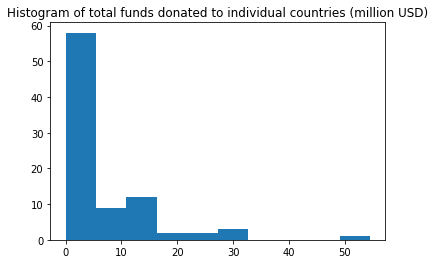

In [19]:
# abbreviate the numbers into millions
funded_amount_in_millions = tab2['sum_of_funded_amount']/1000000

# display a summary of the data
print("Characteristics of total funds donated to individual countries in million USD")
print(funded_amount_in_millions.describe())
print('')

# plot all contributions recieved by individual countries
fig, ax = plt.subplots()

ax.hist(funded_amount_in_millions)

ax.set_title("Histogram of total funds donated to individual countries (million USD)")
plt.show()

In [20]:
# create a pivot-table
loans_per_country = pd.pivot_table(loan_data, values='id', index=['country'], aggfunc='count')

# sort the results in descending order
loans_per_country = loans_per_country.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
loans_per_country.columns = ['number_of_loans']

# make some index entries into columns
loans_per_country = loans_per_country.reset_index(level=['country'])

# and display top 10 results
loans_per_country.head(10)

,country,number_of_loans
0,Philippines,160441
1,Kenya,75825
2,El Salvador,39875
3,Cambodia,34836
4,Pakistan,26857
5,Peru,22233
6,Colombia,21995
7,Uganda,20601
8,Tajikistan,19580
9,Ecuador,13521


In [21]:
# initial status message
print('The shape of tab2 before merge: ', tab2.shape)

# join the data, keeping only relevant entries
tab2 = tab2.merge(loans_per_country, on='country')

# final status message
print('The shape of tab2 after merge: ', tab2.shape)

The shape of tab2 before merge:  (87, 2)
The shape of tab2 after merge:  (87, 3)


In [22]:
# add a calculated column to the newly merged tab2
tab2.loc[:, 'contribution_per_loan'] = tab2['sum_of_funded_amount']/tab2['number_of_loans']

# sort the results in descending order
tab2 = tab2.sort_values(by=['contribution_per_loan'], ascending=True)

# and display top 10 results
tab2.head(20)

,country,sum_of_funded_amount,number_of_loans,contribution_per_loan
86,Virgin Islands,0.0,2,0.000000
46,Nigeria,1905325.0,10136,187.976026
52,Togo,1486800.0,5749,258.618890
54,Liberia,1168225.0,3682,317.280011
53,Madagascar,1223575.0,3821,320.223763
0,Philippines,54476375.0,160441,339.541483
58,Cameroon,875500.0,2230,392.600897
85,Guam,395.0,1,395.000000
1,Kenya,32248405.0,75825,425.300429
71,Nepal,307625.0,717,429.044630


##### 5. What is the geographical footprint of where funds given by KIVA donors end up?

In [23]:
# make a copy of the loan_data dataset and combine it with partner data
loan_data_copy = loan_data.copy()

# ensure that the common column is the same datatype and they share the same name
# the datatype chosen was float64 to preserve any decimal points
print(loan_data_copy.iloc[:,10].name) # original name; stays the same
print('')

print(regional_lts.iloc[:,0].name) #original name - will be changed
#change column name
regional_lts.columns = ['partner_id', 'Field Partner Name', 'sector',
                        'Loan Theme ID', 'Loan Theme Type', 'country',
                        'forkiva', 'region', 'geocode_old',
                        'ISO', 'number', 'amount',
                        'LocationName', 'geocode', 'names',
                        'geo', 'lat', 'lon',
                        'mpi_region', 'mpi_geo', 'rural_pct']
# confirm change
print(regional_lts.iloc[:,0].name)

# change the datatype
regional_lts.iloc[:,0] = regional_lts.iloc[:,0].astype('float64')

partner_id

Partner ID
partner_id


In [24]:
regional_lts.dtypes

partner_id            float64
Field Partner Name     object
sector                 object
Loan Theme ID          object
Loan Theme Type        object
country                object
forkiva                object
region                 object
geocode_old            object
ISO                    object
number                  int64
amount                  int64
LocationName           object
geocode                object
names                  object
geo                    object
lat                   float64
lon                   float64
mpi_region             object
mpi_geo                object
rural_pct             float64
dtype: object

In [25]:
regional_lts.shape

(15736, 21)

In [26]:
# create a pivot-table
tab3 = pd.pivot_table(loan_data_copy, values='funded_amount', index=['partner_id'], aggfunc='sum')

# sort the results in descending order
tab3 = tab3.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab3.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab3 = tab3.reset_index(level=['partner_id'])

# and display top 10 results
tab3.head(10)

,partner_id,sum_of_funded_amount
0,145.0,34127900.0
1,58.0,29412700.0
2,119.0,16908125.0
3,161.0,12401075.0
4,199.0,11971400.0
5,80.0,10042325.0
6,160.0,9826425.0
7,177.0,9432475.0
8,77.0,9118275.0
9,204.0,8515250.0


In [27]:
# create a pivot-table
tab4 = pd.pivot_table(regional_lts, values='amount',
                      index=['partner_id', 'Field Partner Name',
                             'country'],
                      aggfunc='count')

# sort the results in descending order
tab4 = tab4.sort_values(by=['amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab4.columns = ['count_of_amount']

# make some index entries into columns
tab4 = tab4.reset_index(level=['partner_id', 'Field Partner Name', 'country'])

# and display top 10 results
tab4.head(10)

,partner_id,Field Partner Name,country,count_of_amount
0,123.0,Alalay sa Kaunlaran (ASKI),Philippines,1207
1,169.0,SEF International,Armenia,992
2,136.0,Gata Daku Multi-purpose Cooperative (GDMPC),Philippines,952
3,126.0,Paglaum Multi-Purpose Cooperative (PMPC),Philippines,673
4,177.0,Interactuar,Colombia,671
5,121.0,Thanh Hoa Microfinance Institution,Vietnam,666
6,15.0,South Pacific Business Development (SPBD) - Samoa,Samoa,398
7,171.0,Bai Tushum Bank,Kyrgyzstan,393
8,452.0,African Clean Energy (ACE),Lesotho,336
9,204.0,VisionFund Cambodia,Cambodia,324


In [28]:
# create a pivot-table
tab5 = pd.pivot_table(loan_data_copy, values='id', index=['partner_id'], aggfunc='count')

# sort the results in descending order
tab5 = tab5.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
tab5.columns = ['number_of_loans']

# make some index entries into columns
tab5 = tab5.reset_index(level=['partner_id'])

# and display top 10 results
tab5.head(10)

,partner_id,number_of_loans
0,145.0,107188
1,199.0,19446
2,177.0,16414
3,311.0,15837
4,156.0,15516
5,125.0,15010
6,126.0,14374
7,247.0,13661
8,81.0,13390
9,138.0,13306


In [29]:
# initial status message
print('The shape of tab3 before merge: ', tab3.shape)

# join the data, keeping only relevant entries
tab3 = tab3.merge(tab5, on='partner_id')

# final status message
print('The shape of tab3 after merge: ', tab3.shape)

The shape of tab3 before merge:  (366, 2)
The shape of tab3 after merge:  (366, 3)


In [30]:
# initial status message
print('The shape of tab3 before merge: ', tab3.shape)

# join the data, keeping only relevant entries
tab3 = tab3.merge(tab4, on='partner_id')

# final status message
print('The shape of tab3 after merge: ', tab3.shape)

The shape of tab3 before merge:  (366, 3)
The shape of tab3 after merge:  (331, 6)


In [31]:
percentage2 = tab3.shape[0]/366 * 100
percentage2 = round(percentage2, 0)

print('Out of the 366 partners that disbursed loans, KIVA had the contact details of '+str(percentage2)+'% of them.')

Out of the 366 partners that disbursed loans, KIVA had the contact details of 90.0% of them.


In [32]:
# to have more details of the partners that received the most funding by KIVA,
# sort the results in descending order
tab3 = tab3.sort_values(by=['sum_of_funded_amount'], ascending=False)

# drop the unecessary columns
tab3 = tab3.drop('count_of_amount',1)

# display top 10 results; do they match with the original tab3?
tab3.head(10)

,partner_id,sum_of_funded_amount,number_of_loans,Field Partner Name,country
0,145.0,34127900.0,107188,Negros Women for Tomorrow Foundation (NWTF),Philippines
1,58.0,29412700.0,11903,FundaciÍ_n Paraguaya,Paraguay
2,119.0,16908125.0,9825,AsociaciÍ_n Arariwa,Peru
3,161.0,12401075.0,5013,Urwego Opportunity Bank,Rwanda
4,199.0,11971400.0,19446,CrediCampo,El Salvador
5,80.0,10042325.0,6950,Palestine for Credit & Development (FATEN),Palestine
6,160.0,9826425.0,1984,Hekima,The Democratic Republic of the Congo
7,177.0,9432475.0,16414,Interactuar,Colombia
8,77.0,9118275.0,6051,Al Majmoua,Lebanon
9,204.0,8515250.0,10959,VisionFund Cambodia,Cambodia


They match! The Partner IDs are exactly the same in both lists.

In [33]:
# add a calculated column to the newly merged tab3
tab3.loc[:, 'contribution_per_loan'] = tab3['sum_of_funded_amount']/tab3['number_of_loans']

# sort the results in descending order
tab3 = tab3.sort_values(by=['contribution_per_loan'], ascending=False)

# and display top 25 results
tab3.head(25)

,partner_id,sum_of_funded_amount,number_of_loans,Field Partner Name,country,contribution_per_loan
282,482.0,50000.0,1,"N/A, direct to Mavuno Harvest",Uganda,50000.0
280,490.0,50000.0,1,"N/A, direct to Farmerline",Ghana,50000.0
272,514.0,50000.0,1,"N/A, direct to Industria del Alimentos Procesa...",Ecuador,50000.0
271,516.0,50000.0,1,"N/A, direct to Simusolar",Tanzania,50000.0
273,512.0,50000.0,1,"N/A, direct to EcoZoom",Kenya,50000.0
270,517.0,50000.0,1,"N/A, direct to ECEG",Guatemala,50000.0
269,520.0,50000.0,1,"N/A, direct to Moko Furniture (Watervale Inves...",Kenya,50000.0
276,505.0,50000.0,1,"N/A, direct to Eco Fuels Kenya",Kenya,50000.0
266,526.0,50000.0,1,"N/A, direct to Pawame",Kenya,50000.0
277,503.0,50000.0,1,"N/A, direct to Vitalite",Zambia,50000.0


The per capita contribution shows most of the largest contributions per loan actually went directly to social impact businesses.

#### The characteristics of KIVA borrowers

In this section, we seek to understand KIVA borrower characteristics.

##### 1. What is the size of the shortfall for each individual borrower in a given sector?

In [34]:
# create a pivot-table
tab6 = pd.pivot_table(loan_data_copy, values='funded_amount', index=['sector'], aggfunc='sum')

# sort the results in descending order
tab6 = tab6.sort_values(by=['funded_amount'], ascending=False)

# rename the aggregated column to an appropiate label
tab6.columns = ['sum_of_funded_amount']

# make some index entries into columns
tab6 = tab6.reset_index(level=['sector'])

# and display top 10 results
tab6.head(10)

,sector,sum_of_funded_amount
0,Agriculture,133770635.0
1,Food,115089210.0
2,Retail,90864855.0
3,Services,42966085.0
4,Clothing,34805270.0
5,Education,30044920.0
6,Housing,21377100.0
7,Personal Use,14189775.0
8,Arts,11821055.0
9,Transportation,9842500.0


In [35]:
loans_by_sector = pd.pivot_table(loan_data_copy, values='id', index=['sector'], aggfunc='count')

# sort the results in descending order
loans_by_sector = loans_by_sector.sort_values(by=['id'], ascending=False)

# rename the aggregated column to an appropiate label
loans_by_sector.columns = ['number_of_loans']

# make some index entries into columns
loans_by_sector = loans_by_sector.reset_index(level=['sector'])

# and display top 10 results
loans_by_sector.head(10)

,sector,number_of_loans
0,Agriculture,180302
1,Food,136657
2,Retail,124494
3,Services,45140
4,Personal Use,36385
5,Housing,33731
6,Clothing,32742
7,Education,31013
8,Transportation,15518
9,Arts,12060


In [36]:
# create a pivot-table
loan_amounts_by_sector = pd.pivot_table(loan_data_copy, values='loan_amount', index=['sector'], aggfunc='sum')

# sort the results in descending order
loan_amounts_by_sector = loan_amounts_by_sector.sort_values(by=['loan_amount'], ascending=False)

# rename the aggregated column to an appropiate label
loan_amounts_by_sector.columns = ['sum_of_loan_amount']

# make some index entries into columns
loan_amounts_by_sector = loan_amounts_by_sector.reset_index(level=['sector'])

# and display top 10 results
loan_amounts_by_sector.head(10)

,sector,sum_of_loan_amount
0,Agriculture,143067875.0
1,Food,121606150.0
2,Retail,98122900.0
3,Services,48057450.0
4,Clothing,37300925.0
5,Education,30968525.0
6,Housing,23663950.0
7,Personal Use,14955350.0
8,Arts,12240325.0
9,Transportation,11066900.0


In [37]:
# initial status message
print('The shape of tab6 before merge: ', tab6.shape)

# join the data, keeping only relevant entries
tab6 = tab6.merge(loans_by_sector, on='sector')

# final status message
print('The shape of tab6 after merge: ', tab6.shape)

The shape of tab6 before merge:  (15, 2)
The shape of tab6 after merge:  (15, 3)


In [38]:
# initial status message
print('The shape of tab6 before merge: ', tab6.shape)

# join the data, keeping only relevant entries
tab6 = tab6.merge(loan_amounts_by_sector, on='sector')

# final status message
print('The shape of tab6 after merge: ', tab6.shape)

The shape of tab6 before merge:  (15, 3)
The shape of tab6 after merge:  (15, 4)


In [39]:
# assess additional metrics
tab6.loc[:, 'donor_contribution_per_loan'] = tab6['sum_of_funded_amount']/tab6['number_of_loans']
tab6.loc[:, 'funding_gap_per_loan'] = (tab6['sum_of_loan_amount'] - tab6['sum_of_funded_amount'])/tab6['number_of_loans']

# display all results
tab6

,sector,sum_of_funded_amount,number_of_loans,sum_of_loan_amount,donor_contribution_per_loan,funding_gap_per_loan
0,Agriculture,133770635.0,180302,143067875.0,741.925408,51.564819
1,Food,115089210.0,136657,121606150.0,842.175739,47.688300
2,Retail,90864855.0,124494,98122900.0,729.873367,58.300360
3,Services,42966085.0,45140,48057450.0,951.840607,112.790541
4,Clothing,34805270.0,32742,37300925.0,1063.016004,76.221825
5,Education,30044920.0,31013,30968525.0,968.784703,29.781221
6,Housing,21377100.0,33731,23663950.0,633.752335,67.796686
7,Personal Use,14189775.0,36385,14955350.0,389.989694,21.040951
8,Arts,11821055.0,12060,12240325.0,980.186982,34.765340
9,Transportation,9842500.0,15518,11066900.0,634.263436,78.901920


##### 7. How were loans distributed across the genders?

In [ ]:
# create a pivot-table
loans_by_sector = pd.pivot_table(loan_data_copy, values='loan_amount', index=['sector'], aggfunc='sum')

# sort the results in descending order
loans_by_sector = loans_by_sector.sort_values(by=['loan_amount'], ascending=False)

# rename the aggregated column to an appropiate label
loans_by_sector.columns = ['sum_of_loan_amount']

# make some index entries into columns
loans_by_sector = loans_by_sector.reset_index(level=['sector'])

# and display top 10 results
loans_by_sector.head(10)

In [ ]:
loan_data_copy.head(3)

In [ ]:
loan_data_copy.borrower_genders.unique()

##### 9. What was the frequency of repayment of these loans?

funded amount and number of borrowers

##### 10. What is the predominant use of these funds?

text analysis of use in loan_data

#### Global welfare

In this section, we seek to explore the data to understand the financial well-being of various countries

##### 1. How much does the average citizen of each country earn on a regular basis?

2011 PPP (slice a copy of the data and describe this data) then compare this metric to per capita contribution (via share of wallet) adjusted for the loan term (to make all time as homogenous as possible - expressed on an annual basis) and the loan amount itself

##### 2. How much does the average citizen of each country spend on a regular basis?

PCE data then compare this metric to the loan amount adjusted for the loan term

##### 3. What level of poverty does the average citizen of each country experience?

MPI over time